# Convolutional Autoencoders - Tiny ImageNet dataset


**Tiny ImageNet** brings together a large number of 64x64 color images grouped into 200 classes. Initially we will be working with the 10,000 images in the test folder to avoid performance problems.  Once we have the model built, we can use larger amounts of data.

We are going to download the dataset from the *Stanford University* server, unzip it and make sure to load only those images that have all **3 RGB channels**:

In [0]:
!wget -nc http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq ./tiny-imagenet-200.zip

--2019-02-06 18:17:33--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  20.3MB/s    in 19s     

2019-02-06 18:17:52 (12.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt

from tensorflow.keras.layers  import *
from PIL import Image
from os import listdir

path = "./tiny-imagenet-200/test/images/"  # path in the local directory

files = listdir(path)  # all the files in this directory

imgs = np.zeros((len(files), 64, 64, 3))  # format of a single image

for f in range(len(files)):
  img = plt.imread(path + files[f])

  if (len(img.shape) == 3):  # We avoid loading files that don't have 3 color channels.
    imgs[f] = img / 255.

In [0]:
indexes = np.random.permutation(imgs.shape[0])  # random indexes list
train_n = int(imgs.shape[0] * 0.8)  # fractioning training set/test set: 80%/20%
training_idx, test_idx = indexes[:train_n], indexes[train_n:]
imgs_train, imgs_test = imgs[training_idx,:], imgs[test_idx,:]  # Obtain the image partition

img_dim = imgs[0].shape[0]  # 64x64 pixels each image

## Training the autoencoder

Once the training and test partitions are correctly defined, we are going to design and train a Convolutional Autoencoder that, given an input image, compresses this image and recovers it.

The architecture of the Convolutional Autoencoder has been determined after an extensive number of tests of different architectures. It should be noted that **pooling layers** have been used instead of strided convolution. In addition, flattening the latent space to a vector worsens the performance of the CAE, so the latent space has a dimension of 16x16x32.

The ***Adadelta*** optimizer has proven to be the one that converges to a lower validation loss, compared to other optimizers such as *Stochastic Gradient Descent*, *Adam*, *RMSprop* and *Adagrad*, which have been tested under the same conditions:

In [0]:
from tensorflow.python.keras.layers import Conv2D, Input, Dense, Reshape, Flatten, BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

  # Encoder     ###############################################################
  
img = Input(shape=(img_dim, img_dim, 3), name='image')  # image shape: 64x64x3
print("Enc: ", img.shape)
x = Conv2D(kernel_size=3, strides=1, filters=64, padding='same', activation='relu', name='con1e')(img)
x = MaxPooling2D(pool_size=2)(x)
print("Enc: ", x.shape)  # 32x32x32
x = Conv2D(kernel_size=3, strides=1, filters=32, padding='same', activation='relu', name='con2e')(x)
enc_img = MaxPooling2D(pool_size=2)(x)
print("Enc: ", enc_img.shape)  # 16x16x32

###############################################################################

latent = Input(shape=(16, 16, 32), name='latent')  # latent space: 16x16x32

x = Conv2D(kernel_size=3, strides=1, filters=32, padding='same', activation='relu', name='con1d')(latent)
x = UpSampling2D(2)(x)
print("Dec: ", x.shape)  # 32x32x32

x = Conv2D(kernel_size=3, strides=1, filters=64, padding='same', activation='relu', name='con2d')(x)
x = UpSampling2D(2)(x)
print("Dec: ", x.shape)  # 64x64x64

dec_img = Conv2D(kernel_size=3, strides=1, filters=3, padding='same', activation='sigmoid', name='con3d')(x)
print("Dec: ", dec_img.shape)  # 64x64x3

###############################################################################

enc = Model(img, enc_img, name='encoder')
dec = Model(latent, dec_img, name='decoder')

img_input = Input(shape=(img_dim, img_dim, 3), name = 'image_input')
CAE = Model(img_input, dec(enc(img_input)))  # connecting encoder-decoder graphs


checkpoint = ModelCheckpoint(filepath='./weights-CAE.h5', monitor='val_loss', verbose=1, save_best_only='True', save_weights_only='True')

cbks = [EarlyStopping(monitor='loss', patience=7, verbose=1, min_delta=1e-5),  # Stop after 7 epochs if val_loss does not improve
        checkpoint]

CAE.compile(optimizer='adadelta',  # It is recommended to leave the parameters of adadelta at their default values
            loss='mse')

Enc:  (?, 64, 64, 3)
Enc:  (?, 32, 32, 64)
Enc:  (?, 16, 16, 32)
Dec:  (?, 32, 32, 32)
Dec:  (?, 64, 64, 64)
Dec:  (?, 64, 64, 3)


In [0]:
CAE_hist = CAE.fit(imgs_train,
          imgs_train,
          batch_size=4,
          epochs=35,
          verbose=1,
          validation_data=(imgs_test, imgs_test),
          callbacks=cbks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/35
7984/8000 [============================>.] - ETA: 0s - loss: 0.0191
Epoch 00001: val_loss improved from inf to 0.01277, saving model to ./weights-CAE.h5
8000/8000 [==============================] - 23s 3ms/sample - loss: 0.0191 - val_loss: 0.0128
Epoch 2/35
7996/8000 [============================>.] - ETA: 0s - loss: 0.0124
Epoch 00002: val_loss improved from 0.01277 to 0.01024, saving model to ./weights-CAE.h5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0124 - val_loss: 0.0102
Epoch 3/35
7992/8000 [============================>.] - ETA: 0s - loss: 0.0111
Epoch 00003: val_loss did not improve from 0.01024
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0111 - val_loss: 0.0113
Epoch 4/35
7996/8000 [============================>.] - ETA: 0s - loss: 0.0103
Epoch 00004: val_loss did not improve from 0.01024
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0103 - v

In [0]:
CAE.load_weights('./weights-CAE.h5')  # Load the model that reached the best val_loss

Let's visualize the effectiveness of the Convolutional Autoencoder. To do this, we randomly select 4 images that will be reconstructed:

In [0]:
import random

maxval = imgs_test.shape[0]

rows = 2
cols = 4  # different images to plot in the comparison

rand1, rand2, rand3, rand4 = random.sample(range(0, maxval), cols)
print(rand1, rand2, rand3, rand4)

1020 632 506 1708


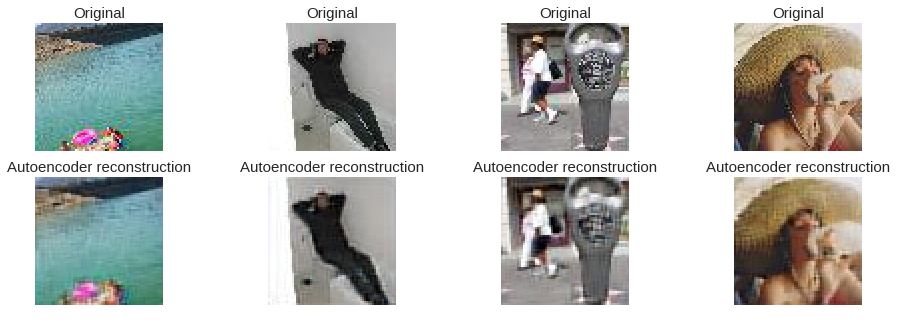

In [0]:
origX = imgs_test[[rand1, rand2, rand3, rand4],:]
predX = np.clip(CAE.predict(origX), 0., 1.)  # Maybe the CAE will return a value out of range, we fix it

fig = plt.figure(figsize=(16, 8))

ax = []  # list to manipulate each subplot

  # Simple way to plot each set
for i in range(0,4):  # Plot original images
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Original", fontsize=15)
  plt.imshow(origX[i])
  
for i in range(4,8):  # Plot reconstructed images
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Autoencoder reconstruction", fontsize=15)
  plt.imshow(predX[i%4])

plt.show()

As we can see, the Convolutional Autoencoder correctly does its job of compressing-decompressing images, losing some quality, but being reconstructed consistently.

## Training the autoencoder with noised images

Now, if we introduce noise in the images of the test set, could we train a Convolutional Autoencoder that acts as a noise eliminator?

Of course we can, indicating **as input the set of noised images** and **as output the set of original images** (without noise). In this way, we compare the output values with the original input values and calculate the corresponding error:

In [0]:
noise_factor = 0.2

  # Introduce noise randomly
imgs_train_noised = imgs_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs_train.shape)
imgs_test_noised = imgs_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs_test.shape)

imgs_train_noised = np.clip(imgs_train_noised, 0., 1.)  # cut RGB between 0 and 1
imgs_test_noised = np.clip(imgs_test_noised, 0., 1.)

In [14]:
from tensorflow.python.keras.layers import Conv2D, Input, Dense, Reshape, Flatten, BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

  # Encoder     ###############################################################
  
img = Input(shape=(img_dim, img_dim, 3), name='image')  # image shape: 64x64x3
print("Enc: ", img.shape)
x = Conv2D(kernel_size=3, strides=1, filters=64, padding='same', activation='relu', name='con1e')(img)
x = MaxPooling2D(pool_size=2)(x)
print("Enc: ", x.shape)  # 32x32x32
x = Conv2D(kernel_size=3, strides=1, filters=32, padding='same', activation='relu', name='con2e')(x)
enc_img = MaxPooling2D(pool_size=2)(x)
print("Enc: ", enc_img.shape)  # 16x16x32

###############################################################################

latent = Input(shape=(16, 16, 32), name='latent')  # latent space: 16x16x32

x = Conv2D(kernel_size=3, strides=1, filters=32, padding='same', activation='relu', name='con1d')(latent)
x = UpSampling2D(2)(x)
print("Dec: ", x.shape)  # 32x32x32

x = Conv2D(kernel_size=3, strides=1, filters=64, padding='same', activation='relu', name='con2d')(x)
x = UpSampling2D(2)(x)
print("Dec: ", x.shape)  # 64x64x64

dec_img = Conv2D(kernel_size=3, strides=1, filters=3, padding='same', activation='sigmoid', name='con3d')(x)
print("Dec: ", dec_img.shape)  # 64x64x3

###############################################################################

encn = Model(img, enc_img, name='encoder')
decn = Model(latent, dec_img, name='decoder')

img_input = Input(shape=(img_dim, img_dim, 3), name = 'image_input')
CAEn = Model(img_input, decn(encn(img_input)))  # connecting encoder-decoder graphs


checkpoint = ModelCheckpoint(filepath='./weights-CAEn.h5', monitor='val_loss', verbose=1, save_best_only='True', save_weights_only='True')

cbks = [EarlyStopping(monitor='loss', patience=7, verbose=1, min_delta=1e-5),  # Stop after 7 epochs if val_loss does not improve
        checkpoint]

CAEn.compile(optimizer='adadelta',  # It is recommended to leave the parameters of this optimizer at their default values
            loss='mse')

Enc:  (?, 64, 64, 3)
Enc:  (?, 32, 32, 64)
Enc:  (?, 16, 16, 32)
Dec:  (?, 32, 32, 32)
Dec:  (?, 64, 64, 64)
Dec:  (?, 64, 64, 3)


In [16]:
CAEn_hist = CAEn.fit(imgs_train_noised,  # Train: Noised_train-Original_train
          imgs_train,
          batch_size=4,
          epochs=35,
          verbose=1,
          validation_data=(imgs_test_noised, imgs_test),  # Test: Noised_test-Original_test
          callbacks=cbks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/35
7984/8000 [============================>.] - ETA: 0s - loss: 0.0170
Epoch 00001: val_loss improved from inf to 0.01453, saving model to ./weights-CAEn.h5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0170 - val_loss: 0.0145
Epoch 2/35
7984/8000 [============================>.] - ETA: 0s - loss: 0.0136
Epoch 00002: val_loss improved from 0.01453 to 0.01390, saving model to ./weights-CAEn.h5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0136 - val_loss: 0.0139
Epoch 3/35
7996/8000 [============================>.] - ETA: 0s - loss: 0.0126
Epoch 00003: val_loss improved from 0.01390 to 0.01371, saving model to ./weights-CAEn.h5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0126 - val_loss: 0.0137
Epoch 4/35
7976/8000 [============================>.] - ETA: 0s - loss: 0.0120
Epoch 00004: val_loss improved from 0.01371 to 0.01123, saving model to ./weights-CAEn.h

In [0]:
CAEn.load_weights('./weights-CAEn.h5')  # Load the model that reached the best val_loss

And now, let's visualize the effectiveness of the convolutional autoencoder to eliminate noise. To do this, we randomly select another 4 images, to which noise will be added, and the trained Convolutional Autoencoder will be responsible for eliminating as much as possible that noise, acting as a **Denoiser Autoencoder**: 

In [22]:
rows = 3
cols = 4  # different images to plot in the comparison

rand1_, rand2_, rand3_, rand4_ = random.sample(range(0, maxval), 4)
print(rand1_, rand2_, rand3_, rand4_)

1195 315 1440 220


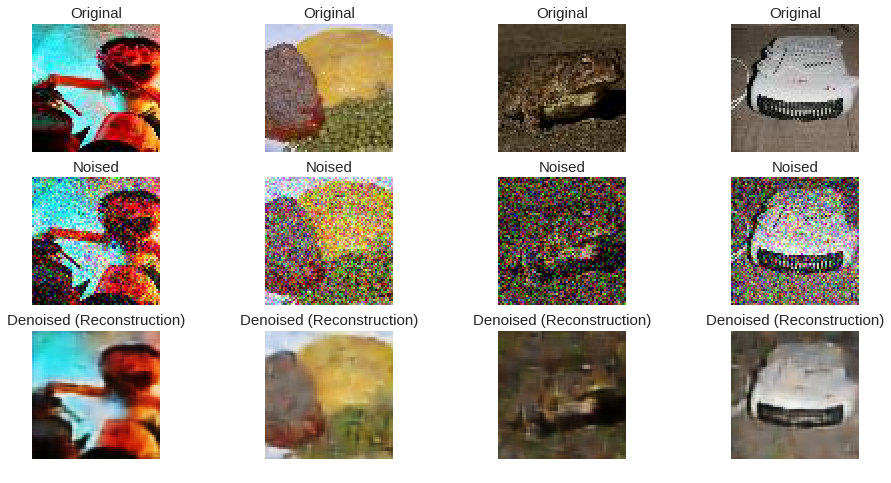

In [23]:
orignX = imgs_test[[rand1_, rand2_, rand3_, rand4_],:]
noisX = imgs_test_noised[[rand1_, rand2_, rand3_, rand4_],:]
prednX = np.clip(CAEn.predict(noisX), 0., 1.)

fig = plt.figure(figsize=(16, 8))

ax = []  # list to manipulate each subplot

for i in range(0,4):
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Original", fontsize=15)
  plt.imshow(orignX[i])
  
for i in range(4,8):
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Noised", fontsize=15)
  plt.imshow(noisX[i%4])
  
for i in range(8,12):
  ax.append(fig.add_subplot(rows, cols, i+1))    
  ax[i].axis('off')
  ax[i].set_title("Denoised (Reconstruction)", fontsize=15)
  plt.imshow(prednX[i%8])

plt.show()

As we can see, there is a slight loss in image quality. However, the Denoiser Autoencoder is able to remove much of the noise, even though the images from **Tiny ImageNet** are low quality. With higher quality images, more refined architectures and more powerful hardware, this practical application of Autoencoders would be of great significance.

## Linear interpolations in latent space

As with the **MNIST** dataset, it is possible to perform linear interpolations in the latent space of an image, in such a way that the transformation from a starting image to a final image is visualized:

In [0]:
from random import randint

rnd1, rnd2 = randint(0, maxval), randint(0, maxval)
print(rnd1, rnd2)

1999 1007


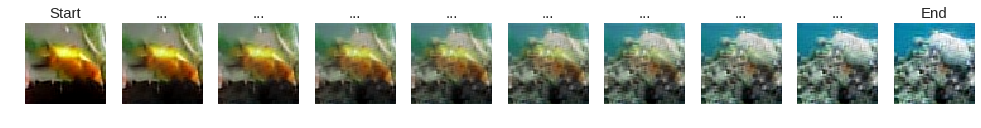

In [0]:
interp_vecs = 10  # Number of interpolations to consider

  # Feed the encoder with the start-end pair
lv = enc.predict(imgs_test[[rnd1, rnd2],:])

fig, ax = plt.subplots(1, interp_vecs, figsize=(17,17))

coeffs = np.linspace(0,1,interp_vecs)

for i, coef in enumerate(coeffs):
  
  # The latent vector is a linear combination between start and end numbers
  vec = lv[0]*(1-coef) + lv[1]*coef
  # Feed the latent vector to the decoder to generate a mixtured reconstruction
  reconstr = np.clip(dec.predict(vec.reshape(1, 16, 16, 32)), 0., 1.)  # shape of latent space
    
  ax[i].imshow(reconstr.reshape(img_dim, img_dim, 3))
  ax[i].axis('off')
  ax[i].set_title('...', fontsize=15)

ax[0].set_title("Start", fontsize=15)
ax[interp_vecs-1].set_title("End", fontsize=15)

plt.show()

 However, this transformation is not as realistic as with MNIST, as the complexity is greater and it seems a "ghostly" transition. If we wanted to generate realistic images from two color images, [Generative Adversarial Networks (GAN)](https://medium.com/@ekss1121/generative-adversarial-networks-b9f80e6d7679) would be the right approach.